In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

np.random.seed(12211)  

# import SetPub
# SetPub.set_pub()

In [2]:
train_mode = True

In [3]:
num_train = 4000 #200000 
num_test = 1000 #20000

In [4]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]
# Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]


In [5]:
n_epochs = 100
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 #16 # number of mixture components

learning_rate = 1e-4
decay_rate= 1e-3 
batch_size = 1024 

save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [6]:
def minmax_cuts(X, y):
    
    mask_cond =  np.where( 
        (X[:, 0] < max_col) & (X[:, 0] > min_col) &
        (X[:, 1] < max_col) & (X[:, 1] > min_col) &
        (X[:, 2] < max_col) & (X[:, 2] > min_col) &
        (X[:, 3] < max_col) & (X[:, 3] > min_col) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    return X_new, y_new, mask_cond

In [7]:
def minmax_cutsOBSarr(X, y, l):
    
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    

    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond


In [8]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [9]:
def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

In [10]:
def shuffleOBS(X, y, l):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    l = l[shuffleOrder]
    return X, y, l, shuffleOrder

In [11]:
def resample(X, y, n_bins = 200):

    select_per_bin = 50 # 50 #np.int(num_train/n_bins) #100

    bins = np.linspace(y.min(), y.max(), n_bins)
    # bins = np.logspace(np.log10(y_test.min()+1e-2), np.log10(y_test.max()+1e-2), n_bins)
    inds = np.digitize(y, bins)

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')
    all_ind = np.arange(y.shape[0])
    # resampled_ind_not = ~np.in1d(np.arange(all_ind.shape[-1]), resampled_ind)

    plt.figure(23)
    plt.hist(y, density=True, bins = n_bins, histtype='step', label='original')
    y_resampled = y[resampled_ind]
    X_resampled = X[resampled_ind]


    plt.hist(y_resampled, density=True, bins = n_bins, histtype='step', label='resampled')
    plt.hist(y_train, density=True, bins = n_bins, histtype='step', label='rest')

    plt.legend()
    plt.show()

    print(y_resampled.shape)
    
    return X_resampled, y_resampled, resampled_ind



In [12]:
def loadTrainTest_july(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_july_2020/'):


    # train_data = np.load(dirIn + 'july13_100k.npy') 
    train_data = np.load(dirIn + 'july14_200k.npy') 
    test_data = np.load(dirIn + 'july13_10k.npy') 
    


    X_train = train_data['color']#[train_data['redshift_flags'] == 0]
    y_train = train_data['redshift']#[train_data['redshift_flags'] == 0]

    # data['colors'] #  colors (ngal, ncols)
    # data['redshifts'] # redshifts

    X_test = test_data['color']#[test_data['redshift_flags'] == 0]
    y_test = test_data['redshift']#[test_data['redshift_flags'] == 0]

    print_limits(X_train, y_train)
    print_limits(X_test, y_test)

    return X_train, y_train, X_test, y_test

# X_train, y_train, _, _ = loadTrainTest_july(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_july_2020/')


In [13]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [18]:
# X_train, y_train, _, _ = loadTrainTest_july(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_july_2020/')
# X_test, y_test, X_err, label_test = loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/')

X_train, y_train, _, _ = loadTrainTest_july(dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Data/fromGalaxev/photozs/datasets/data_july_2020/')
X_test, y_test, X_err, label_test = loadTest(dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/') # data_feb_2021

----------
number of datapoints:  187462
z-minmax:  0.0020016062 1.249997
ColMag-min:  [-0.09145837 -0.05327791 -0.02479261 -0.10519464 12.000012  ]
ColMag-max:  [ 3.825315   2.8303378  1.6937237  1.5019817 23.499979 ]
----------
----------
number of datapoints:  10322
z-minmax:  0.0020014732 1.249283
ColMag-min:  [-4.1676056e-02 -7.1866615e-03  5.6203555e-02 -6.4645730e-02
  1.2003667e+01]
ColMag-max:  [ 3.6190994  2.7985296  1.6097487  1.4396983 23.4981   ]
----------
----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [19]:
X_train, y_train, X_trainShuffleOrder = shuffle(X_train, y_train)
# X_test, y_test, label_test, X_testShuffleOrder = shuffleOBS(X_test, y_test, test_labels)

In [20]:
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.0 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)

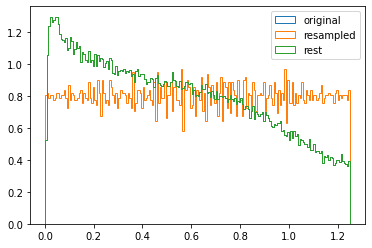

(9950,)


In [21]:
resampleTrain = True

if resampleTrain:
    X_train, y_train, resampled_ind = resample(X_train, y_train)

In [22]:
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (9950, 5)
Size of output in training data: (9950,)
Size of features in test data: (2767, 5)
Size of output in test data: (2767,)


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle


preproc = Pipeline([('stdscaler', StandardScaler())])
# preproc = Pipeline([('stdscaler', MinMaxScaler())])
X_train = preproc.fit_transform(X_train)

scalerfile = save_mod + '_scaling_X'
pickle.dump(preproc, open(scalerfile, 'wb'))
preproc = pickle.load(open(scalerfile, 'rb'))


X_test = preproc.transform(X_test)

# preproc_y = Pipeline([('stdscaler', StandardScaler())])
preproc_y = Pipeline([('stdscaler', MinMaxScaler())])


y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))

scalerfile = save_mod + '_scaling_y'
pickle.dump(preproc_y, open(scalerfile, 'wb'))
preproc_y = pickle.load(open(scalerfile, 'rb'))

y_test = preproc_y.transform(y_test.reshape(-1, 1))

In [24]:
print_limits(X_train, y_train)

print_limits(X_test, y_test)

----------
number of datapoints:  9950
z-minmax:  0.0 0.99999994
ColMag-min:  [-1.6409001 -2.280429  -2.1727188 -2.2547731 -4.2329054]
ColMag-max:  [4.6897407 3.7267692 3.5270236 3.8686678 1.2576239]
----------
----------
number of datapoints:  2767
z-minmax:  -0.0016874264 0.8794259
ColMag-min:  [-1.6361253 -2.2358537 -2.3130894 -2.3068612 -4.1867476]
ColMag-max:  [4.7729926 4.186437  3.6221097 3.9470558 1.0187622]
----------


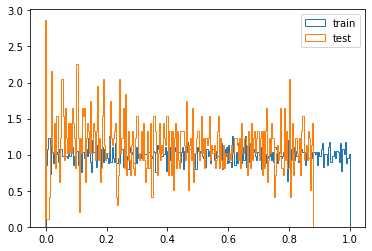

In [25]:
plt.figure(23)

plt.hist(y_train, density=True, bins = 250, histtype='step', label='train')
plt.hist(y_test, density=True, bins = 250, histtype='step', label='test')
plt.legend()

In [26]:
def decay(epoch):
    if (epoch < 1):
        return learning_rate
    else:
        return learning_rate*(1.0/(1.0+decay_rate*(epoch)))

In [27]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model_train.optimizer.lr.numpy()))

In [28]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [29]:
# x = tf.keras.layers.InputLayer(input_shape=(D,)),
non_lin_act = tf.nn.relu #tf.nn.tanh
y_true = tf.keras.Input(shape=(1,))
inputs = tf.keras.Input(shape=(D,))
layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)

In [30]:
model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')

In [31]:
# Define custom loss
def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, mu, var, pi):
        mixture_distribution = tfp.distributions.Categorical(probs=pi)
        distribution = tfp.distributions.Normal(loc=mu, scale=var)
        likelihood = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture_distribution,components_distribution=distribution)

        log_likelihood = -1.0*likelihood.log_prob(tf.transpose(y_true))
        mean_loss = tf.reduce_mean(log_likelihood)

        return mean_loss
   
    return loss
    

model_train.add_loss(custom_loss(inputs)(y_true, mu, var, pi))

model_train.compile(optimizer='Nadam')
model_train.summary()

Model: "mdn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          3072        input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         525312      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         2099200     dense_1[0][0]                    
________________________________________________________________________________________________

Epoch 1/100
9/9 [==============================] - 2s 47ms/step - loss: 1.6342 - val_loss: 1.6502

Learning rate for epoch 1 is 9.999999747378752e-05
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 1.4688 - val_loss: 1.0409

Learning rate for epoch 2 is 9.990009857574478e-05
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 1.0388 - val_loss: 0.9685

Learning rate for epoch 3 is 9.980039612855762e-05
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.9449 - val_loss: 0.9317

Learning rate for epoch 4 is 9.970089740818366e-05
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.9395 - val_loss: 0.9305

Learning rate for epoch 5 is 9.960159513866529e-05
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 0.9334 - val_loss: 0.9262

Learning rate for epoch 6 is 9.95024893200025e-05
Epoch 7/100
9/9 [==============================] - 0s 19ms/step - loss: 0.9291 - val_loss: 0.9261

Le

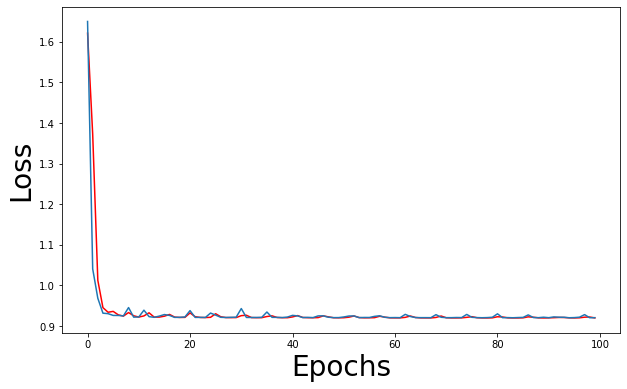

In [32]:

if train_mode:

    history = model_train.fit([X_train, y_train], validation_split = 0.1, epochs=n_epochs, batch_size = batch_size, callbacks=callbacks)


    model_train.save_weights(save_mod + '.h5')

    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

In [33]:
model_train.load_weights(save_mod + '.h5')

In [37]:
y_pred = np.array(model_train(  X_test, np.zeros(shape = X_test.shape[1]) ))

y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))

InvalidArgumentError: Incompatible shapes: [1,5,1] vs. [2767,3] [Op:RealDiv]

In [ ]:
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
y_pred_3weights = y_pred[2, :, :]

y_test_all = preproc_y.inverse_transform(y_test)


predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
truelabel = np.array([y_test_all[:, 0], label_test])

np.save(save_mod+'test_true', predstdweights )
np.save(save_mod+'test_pred', truelabel )

In [ ]:
ifPlotWeighted = True
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std

if ifPlotWeighted:
    

    colorstring = ['b', 'r', 'g', 'k', 'orange']
    surveystring = ['SDSS', 'VIPERS', 'DEEP2']

    plt.figure(22, figsize=(10, 10,))

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)

    plt.plot(z_t, z_t, 'k')
    plt.plot(z_t, z_tp, 'k-.')
    plt.plot(z_t, z_tm, 'k-.')

    for label_ind in [0, 1, 2]:
        surveyindx = np.where(label_test == label_ind)
        offset = 0.0
        
        plt.errorbar(preproc_y.inverse_transform(y_test)[surveyindx][:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind], c = colorstring[label_ind])



plt.ylabel(r'$z_{phot}$', fontsize=25)
plt.xlabel(r'$z_{spec}$', fontsize=25)
        
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

plt.tight_layout()
# plt.axes().set_aspect('equal')

leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)
plt.savefig('phoz_compare_surveys.pdf', bbox_inches='tight')
plt.show()
